In [ ]:
os._exit(0)

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler
from transformers import AutoTokenizer
from datasets import load_dataset
from accelerate import notebook_launcher
from accelerate import Accelerator
import os
import random
import wandb

In [2]:
# Load the Multi30k dataset
dataset = load_dataset("cfilt/iitb-english-hindi")

Generating train split:   0%|          | 0/1659083 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/520 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2507 [00:00<?, ? examples/s]

In [3]:
from transformers import BertTokenizer, DataCollatorForSeq2Seq

2024-06-07 08:52:34.277905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 08:52:34.278013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 08:52:34.430301: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
# Create a config for the model
config = {
    'n_embed': 512,
    'n_head': 16,
    'n_layer': 6,
    'block_size': 128,
    'dropout': 0.1,
    'batch_size': 128,
    'lr': 1,
    'tokenizer': 'bert-base-uncased',
    'vocab_size': tokenizer.vocab_size,
    'mixed_precision': 'fp16'
}

# Config for testing a small model
# config = {
#     'n_embed': 32,
#     'n_head': 2,
#     'n_layer': 2,
#     'block_size': 16,
#     'dropout': 0.1,
#     'batch_size': 8,
#     'lr': 2e-1,
#     'tokenizer': 'bert-base-uncased',
# }

In [97]:
wandb.finish()

In [6]:
wandb.init(
    project='Transformer_eng_to_hin',
    entity='ritishtest1',
    id='mgnq1341',
    resume='must',

    config=config
    )

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
wandb.run.id

'mgnq1341'

In [9]:
dtr = dataset['train']['translation']
dval = dataset['validation']['translation']

In [10]:
from datasets import Dataset

new_data_train = {'en':[], 'hi':[]}
new_data_val = {'en':[], 'hi':[]}

for entry in dtr:
    new_data_train['en'].append(entry['en'])
    new_data_train['hi'].append(entry['hi'])
    
for entry in dval:
    new_data_val['en'].append(entry['en'])
    new_data_val['hi'].append(entry['hi'])
    
tmp_train = list(zip(new_data_train['en'], new_data_train['hi']))
random.shuffle(tmp_train)
new_data_train['en'], new_data_train['hi'] = zip(*tmp_train)
    
train = Dataset.from_dict(new_data_train)
val = Dataset.from_dict(new_data_val)

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, causal, cross=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.causal = causal
        self.cross = cross
        self.q_attn = nn.Linear(config['n_embed'], config['n_embed'], bias=False)
        self.kv_attn = nn.Linear(config['n_embed'], config['n_embed'] * 2, bias=False)
        self.c_proj = nn.Linear(config['n_embed'], config['n_embed'], bias=False)             # Combine the outputs of the heads
        self.attn_dropout = nn.Dropout(config['dropout'])
        self.resid_dropout = nn.Dropout(config['dropout'])

        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        # self.flash = False

        if not self.flash:
            print("WARNING: using slow attention.")
            # self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size))
            self.register_buffer("tril", torch.tril(torch.ones(config['block_size'], config['block_size'])))

    def forward(self, x, y=None, mask=None):
        B, T_dec, C = x.shape

        if y is None:
            y = x

        B, T_enc, C = y.shape

        # Query from the decoder
        q = self.q_attn(x).view(B, T_dec, self.num_heads, self.head_size).transpose(1, 2)  # (B,T_dec,C) -> (B,T_dec,nh,hs) -> (B,nh,T_dec,hs)
        k, v = self.kv_attn(y).split(C, dim=-1)                                 # (B,T_enc,2C) -> 2*(B,T_enc,C)
        k = k.view(B, T_enc, self.num_heads, self.head_size).transpose(1, 2)    # (B,nh,T_enc,hs)
        v = v.view(B, T_enc, self.num_heads, self.head_size).transpose(1, 2)    # (B,nh,T_enc,hs)

        if self.flash:
            out = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, is_causal=self.causal)
        else:
            wei = q @ k.transpose(-2, -1) * 1.0 / math.sqrt(k.size(-1))         # (B,nh,T_dec,hs) @ (B,nh,hs,T_enc) -> (B,nh,T_dec,T_enc)
            if self.causal:
                if mask is None:
                    # Lower triangular mask to mask future tokens
                    wei = wei.masked_fill(self.tril[:T_dec, :T_enc] == 0, float('-inf')) # (B,nh,T_dec,T_enc)
                else:
                    wei = wei.masked_fill(mask == 0, float('-inf'))             # (B,nh,T_dec,T_enc)
            wei = F.softmax(wei, dim=-1)                                        # (B,nh,T_dec,T_enc)
            wei = self.attn_dropout(wei)
            out = wei @ v                                                       # (B,nh,T_dec,T_enc) @ (B,nh,T_enc,hs) -> (B,nh,T_dec,hs)

        out = out.transpose(1, 2).contiguous().view(B, T_dec, -1)               # (B,T_dec,nh*hs) = (B,T_dec,C)
        out = self.resid_dropout(self.c_proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            # nn.ReLU(),
            nn.GELU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(config['dropout']),
        )

    def forward(self, x):
        return self.net(x)

class DecoderBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embed, n_head, cross=False):
        # n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.cross = cross
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size, causal=True, cross=False)               # Masked MHA
        if self.cross:
            # Cross attention block
            self.cross_sa = MultiHeadAttention(n_head, head_size, causal=False, cross=True)     # Cross MHA
            self.ln2 = nn.LayerNorm(n_embed)
        self.ffwd = FeedFoward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        # self.ln2 = nn.LayerNorm(n_embed)
        self.ln3 = nn.LayerNorm(n_embed)

    def forward(self, x, y=None):
        x = x + self.sa(self.ln1(x))
        if self.cross:
            x = x + self.cross_sa(self.ln2(x), y)
        x = x + self.ffwd(self.ln3(x))
        return x

class EncoderBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embed, n_head):
        # n_embed: embedding dimension, nhead: the number of heads we'd like
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size, causal=False, cross=False)
        self.ffwd = FeedFoward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# Encoder-decoder transformer
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        # Create token embedding table
        self.token_embedding_table_enc = nn.Embedding(config['vocab_size'], config['n_embed'])
        self.token_embedding_table_dec = nn.Embedding(config['vocab_size'], config['n_embed'])

        # Create encoder blocks
        self.enc_blocks = nn.Sequential(*[EncoderBlock(config['n_embed'], config['n_head']) for _ in range(config['n_layer'])])

        # Create decoder blocks
        self.dec_blocks = nn.ModuleList([DecoderBlock(config['n_embed'], config['n_head'], cross=True) for _ in range(config['n_layer'])])

        self.ln_f = nn.LayerNorm(config['n_embed'])
        self.lm_head = nn.Linear(config['n_embed'], config['vocab_size'])

    def generate_sinousidal_pos_embeddings(self, T, device):
        pos = torch.arange(T, device=device).view(-1,1)              # (T, 1)
        i = torch.arange(config['n_embed'], device=device).view(1,-1)          # (1, C)
        angles = pos / 10000**(2*i/(config['n_embed']))                        # (T, C)
        angles[:, 0::2] = torch.sin(angles[:, 0::2])
        angles[:, 1::2] = torch.cos(angles[:, 1::2])
        return angles.unsqueeze(0)                                   # (1,T,C)

    def forward(self, enc_inp, dec_inp, targets=None):
        B, T_enc = enc_inp.shape
        B, T_dec = dec_inp.shape

        # enc_inp and targets are both (B,T) tensor of integers
        tok_emb_enc = self.token_embedding_table_enc(enc_inp)                        # (B,T,C)
        tok_emb_dec = self.token_embedding_table_dec(dec_inp)                        # (B,T,C)

        # Encoder and decoder positional embeddings
        pos_emb_enc = self.generate_sinousidal_pos_embeddings(T_enc, device=enc_inp.device)  # (1,T_enc,C)
        pos_emb_dec = self.generate_sinousidal_pos_embeddings(T_dec, device=dec_inp.device)  # (1,T_dec,C)

        x_enc = tok_emb_enc + pos_emb_enc                                        # (B,T_enc,C)
        x_dec = tok_emb_dec + pos_emb_dec                                        # (B,T_dec,C)

        # Get output from encoder and decoder blocks
        x_enc_out = self.enc_blocks(x_enc)                                       # (B,T_enc,C)

        # Give output of the final encoder layer to the decoder layers
        for i in range(config['n_layer']):
            x_dec = self.dec_blocks[i](x_dec, x_enc_out)                         # (B,T_dec,C)

        x = self.ln_f(x_dec)                                                     # (B,T_dec,C)
        logits = self.lm_head(x)                                                 # (B,T_dec,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape

            logits = logits.reshape(B*T, C)
            targets = targets.reshape(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=0)

        return logits, loss

    def generate(self, enc_inp, max_len=config['block_size'], greedy=True):
        with torch.no_grad():
            dec_inp = 101 * torch.ones((1, 1), dtype=torch.long, device=enc_inp.device)

            for i in range(max_len-1):
                dec_inp = dec_inp[:, -config['block_size']:]
                logits, _ = self(enc_inp, dec_inp)
                if greedy:
                    next_token = torch.argmax(logits[:, -1, :], dim=-1).view(-1, 1)
                else:
                    next_token = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), num_samples=1).view(-1, 1)
                dec_inp = torch.cat([dec_inp, next_token], dim=1)
                if next_token == 102:
                    break

        return dec_inp

    def generate_v1(self, enc_inp, max_len=config['block_size'], greedy=True):
        with torch.no_grad():
            dec_inp = 101 * torch.ones((1, 1), dtype=torch.long, device=enc_inp.device)
            enc_inp = enc_inp[:, :config['block_size']]

            B, T_enc = enc_inp.shape
            x_enc = self.token_embedding_table_enc(enc_inp)
            pos_emb_enc = self.generate_sinousidal_pos_embeddings(T_enc, device=enc_inp.device)
            x_enc = x_enc + pos_emb_enc
            x_enc_out = self.enc_blocks(x_enc)

            for i in range(max_len-1):
                dec_inp = dec_inp[:, -config['block_size']:]
                x_dec = self.token_embedding_table_dec(dec_inp)
                pos_emb_dec = self.generate_sinousidal_pos_embeddings(dec_inp.shape[1], device=dec_inp.device)
                x_dec = x_dec + pos_emb_dec

                # Layer wise cross attention
                for j in range(config['n_layer']):
                    x_dec = self.dec_blocks[j](x_dec, x_enc_out)                        # (B,T_dec,C)

                x = self.ln_f(x_dec)                                                    # (B,T_dec,C)
                logits = self.lm_head(x)                                                # (B,T_dec,vocab_size)

                if greedy:
                    next_token = torch.argmax(logits[:, -1, :], dim=-1).view(-1, 1)
                else:
                    next_token = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), num_samples=1).view(-1, 1)
                dec_inp = torch.cat([dec_inp, next_token], dim=1)
                if next_token == 102:
                    break

        return dec_inp
    
# Encoder-decoder transformer with layerwise encoder-decoder connections
class Transformer_v1(nn.Module):
    def __init__(self):
        super().__init__()
        # Create token embedding table
        self.token_embedding_table_enc = nn.Embedding(config['vocab_size'], config['n_embed'])
        self.token_embedding_table_dec = nn.Embedding(config['vocab_size'], config['n_embed'])

        # Create encoder blocks
        self.enc_blocks = nn.ModuleList([EncoderBlock(config['n_embed'], config['n_head']) for _ in range(config['n_layer'])])

        # Create decoder blocks with masked multihead attention followed by cross attention
        self.dec_blocks = nn.ModuleList([DecoderBlock(config['n_embed'], config['n_head'], cross=True) for _ in range(config['n_layer'])])

        self.ln_f = nn.LayerNorm(config['n_embed']) # final layer norm
        self.lm_head = nn.Linear(config['n_embed'], config['vocab_size'])

    def generate_sinousidal_pos_embeddings(self, T, device):
        pos = torch.arange(T, device=device).view(-1,1)              # (T, 1)
        i = torch.arange(config['n_embed'], device=device).view(1,-1)          # (1, C)
        angles = pos / 10000**(2*i/(config['n_embed']))                        # (T, C)
        angles[:, 0::2] = torch.sin(angles[:, 0::2])
        angles[:, 1::2] = torch.cos(angles[:, 1::2])
        return angles.unsqueeze(0)

    def forward(self, enc_inp, dec_inp, targets=None):
        B, T_enc = enc_inp.shape
        B, T_dec = dec_inp.shape

        # enc_inp and targets are both (B,T) tensor of integers
        tok_emb_enc = self.token_embedding_table_enc(enc_inp)                                  # (B,T,C)
        tok_emb_dec = self.token_embedding_table_dec(dec_inp)                                  # (B,T,C)

        # Encoder and decoder positional embeddings
        pos_emb_enc = self.generate_sinousidal_pos_embeddings(T_enc, device=enc_inp.device)        # (1,T_enc,C)
        pos_emb_dec = self.generate_sinousidal_pos_embeddings(T_dec, device=dec_inp.device)        # (1,T_dec,C)

        x_enc = tok_emb_enc + pos_emb_enc                                       # (B,T_enc,C)
        x_dec = tok_emb_dec + pos_emb_dec                                       # (B,T_dec,C)

        # Layer wise cross attention
        for i in range(config['n_layer']):
            x_enc = self.enc_blocks[i](x_enc)                                   # (B,T_enc,C)
            x_dec = self.dec_blocks[i](x_dec, x_enc)                            # (B,T_dec,C)

        x = self.ln_f(x_dec)                                                    # (B,T_dec,C)
        logits = self.lm_head(x)                                                # (B,T_dec,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape

            logits = logits.reshape(B*T, C)
            targets = targets.reshape(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=0)

        return logits, loss

    def generate(self, enc_inp, max_len=config['block_size'], greedy=True):
        self.eval()
        with torch.no_grad():
            dec_inp = 101 * torch.ones((1, 1), dtype=torch.long, device=enc_inp.device)
            enc_inp = enc_inp[:, :config['block_size']]

            for i in range(max_len-1):
                dec_inp = dec_inp[:, -config['block_size']:]
                logits, _ = self(enc_inp, dec_inp)
                if greedy:
                    next_token = torch.argmax(logits[:, -1, :], dim=-1).view(-1, 1)
                else:
                    next_token = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), num_samples=1).view(-1, 1)
                dec_inp = torch.cat([dec_inp, next_token], dim=1)
                if next_token == 102:
                    break

        return dec_inp

    def generate_v1(self, enc_inp, max_len=config['block_size'], greedy=True):
        self.eval()
        with torch.no_grad():
            dec_inp = 101 * torch.ones((1, 1), dtype=torch.long, device=enc_inp.device)
            enc_inp = enc_inp[:, :config['block_size']]

            B, T_enc = enc_inp.shape
            x_enc = self.token_embedding_table_enc(enc_inp)
            pos_emb_enc = self.generate_sinousidal_pos_embeddings(T_enc, device=enc_inp.device)
            x_enc = x_enc + pos_emb_enc
            x_enc_out = torch.zeros((1, config['block_size'], config['n_embed'], config['n_layer'])).to(enc_inp.device)

            # Precompute the encoder outputs
            for i in range(config['n_layer']):
                x_enc = self.enc_blocks[i](x_enc)                                   # (B,T_enc,C)
                x_enc_out[:, :, :, i] = x_enc

            for i in range(max_len-1):
                dec_inp = dec_inp[:, -config['block_size']:]
                x_dec = self.token_embedding_table_dec(dec_inp)
                pos_emb_dec = self.generate_sinousidal_pos_embeddings(dec_inp.shape[1], device=dec_inp.device)
                x_dec = x_dec + pos_emb_dec

                # Layer wise cross attention
                for j in range(config['n_layer']):
                    x_dec = self.dec_blocks[j](x_dec, x_enc_out[:,:,:,j])           # (B,T_dec,C)

                x = self.ln_f(x_dec)                                                # (B,T_dec,C)
                logits = self.lm_head(x)                                            # (B,T_dec,vocab_size)

                if greedy:
                    next_token = torch.argmax(logits[:, -1, :], dim=-1).view(-1, 1)
                else:
                    next_token = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), num_samples=1).view(-1, 1)

                dec_inp = torch.cat([dec_inp, next_token], dim=1)
                if next_token == 102:
                    break

        return dec_inp

In [12]:
class Transformer_v2(nn.Module):
    def __init__(self):
        super().__init__()
        # Create token embedding table
        self.token_embedding_table = nn.Embedding(config['vocab_size'], config['n_embed'])

        # Create encoder blocks
        self.enc_blocks = nn.Sequential(*[EncoderBlock(config['n_embed'], config['n_head']) for _ in range(config['n_layer'])])

        # Create decoder blocks
        self.dec_blocks = nn.ModuleList([DecoderBlock(config['n_embed'], config['n_head'], cross=True) for _ in range(config['n_layer'])])

        self.ln_f = nn.LayerNorm(config['n_embed'])
        self.lm_head = nn.Linear(config['n_embed'], config['vocab_size'])

    def generate_sinousidal_pos_embeddings(self, T, device):
        pos = torch.arange(T, device=device).view(-1,1)              # (T, 1)
        i = torch.arange(config['n_embed'], device=device).view(1,-1)          # (1, C)
        angles = pos / 10000**(2*i/(config['n_embed']))                        # (T, C)
        angles[:, 0::2] = torch.sin(angles[:, 0::2])
        angles[:, 1::2] = torch.cos(angles[:, 1::2])
        return angles.unsqueeze(0)                                   # (1,T,C)

    def forward(self, enc_inp, dec_inp, targets=None):
        B, T_enc = enc_inp.shape
        B, T_dec = dec_inp.shape

        # enc_inp and targets are both (B,T) tensor of integers
        tok_emb_enc = self.token_embedding_table(enc_inp)                        # (B,T,C)
        tok_emb_dec = self.token_embedding_table(dec_inp)                        # (B,T,C)

        # Encoder and decoder positional embeddings
        pos_emb_enc = self.generate_sinousidal_pos_embeddings(T_enc, device=enc_inp.device)  # (1,T_enc,C)
        pos_emb_dec = self.generate_sinousidal_pos_embeddings(T_dec, device=dec_inp.device)  # (1,T_dec,C)

        x_enc = tok_emb_enc + pos_emb_enc                                        # (B,T_enc,C)
        x_dec = tok_emb_dec + pos_emb_dec                                        # (B,T_dec,C)

        # Get output from encoder and decoder blocks
        x_enc_out = self.enc_blocks(x_enc)                                       # (B,T_enc,C)

        # Give output of the final encoder layer to the decoder layers
        for i in range(config['n_layer']):
            x_dec = self.dec_blocks[i](x_dec, x_enc_out)                         # (B,T_dec,C)

        x = self.ln_f(x_dec)                                                     # (B,T_dec,C)
        logits = self.lm_head(x)                                                 # (B,T_dec,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape

            logits = logits.reshape(B*T, C)
            targets = targets.reshape(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=0)

        return logits, loss

    def generate(self, enc_inp, max_len=config['block_size'], greedy=True):
        with torch.no_grad():
            dec_inp = 101 * torch.ones((1, 1), dtype=torch.long, device=enc_inp.device)

            for i in range(max_len-1):
                dec_inp = dec_inp[:, -config['block_size']:]
                logits, _ = self(enc_inp, dec_inp)
                if greedy:
                    next_token = torch.argmax(logits[:, -1, :], dim=-1).view(-1, 1)
                else:
                    next_token = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), num_samples=1).view(-1, 1)
                dec_inp = torch.cat([dec_inp, next_token], dim=1)
                if next_token == 102:
                    break

        return dec_inp

    def generate_v1(self, enc_inp, max_len=config['block_size'], greedy=True):
        with torch.no_grad():
            dec_inp = 101 * torch.ones((1, 1), dtype=torch.long, device=enc_inp.device)
            enc_inp = enc_inp[:, :config['block_size']]

            B, T_enc = enc_inp.shape
            x_enc = self.token_embedding_table(enc_inp)
            pos_emb_enc = self.generate_sinousidal_pos_embeddings(T_enc, device=enc_inp.device)
            x_enc = x_enc + pos_emb_enc
            x_enc_out = self.enc_blocks(x_enc)

            for i in range(max_len-1):
                dec_inp = dec_inp[:, -config['block_size']:]
                x_dec = self.token_embedding_table(dec_inp)
                pos_emb_dec = self.generate_sinousidal_pos_embeddings(dec_inp.shape[1], device=dec_inp.device)
                x_dec = x_dec + pos_emb_dec

                # Layer wise cross attention
                for j in range(config['n_layer']):
                    x_dec = self.dec_blocks[j](x_dec, x_enc_out)                        # (B,T_dec,C)

                x = self.ln_f(x_dec)                                                    # (B,T_dec,C)
                logits = self.lm_head(x)                                                # (B,T_dec,vocab_size)

                if greedy:
                    next_token = torch.argmax(logits[:, -1, :], dim=-1).view(-1, 1)
                else:
                    next_token = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), num_samples=1).view(-1, 1)
                dec_inp = torch.cat([dec_inp, next_token], dim=1)
                if next_token == 102:
                    break

        return dec_inp

In [13]:
model = Transformer()
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
n_epoch = 0
n_step = 0

91.01497 M parameters


In [12]:
# Learning rate scheduling with warmup steps
def lr_scheduler(step, n_embed=config['n_embed'], warmup_steps=400):
    step = max(1, step)
    lr = (n_embed ** -0.5) * min(step ** -0.5, step * warmup_steps ** -1.5)
    return lr

optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler)

In [13]:
train, val

(Dataset({
     features: ['en', 'hi'],
     num_rows: 1659083
 }),
 Dataset({
     features: ['en', 'hi'],
     num_rows: 520
 }))

In [14]:
def training_loop(model, optimizer, scheduler, config, max_epochs, load):
    n_step = 0
    accelerator = Accelerator(mixed_precision=config['mixed_precision'])
    device = accelerator.device
    model = model.to(device)
    optimizer = optimizer
    save_directory = '/kaggle/working/'
    
    # Create dataloader
    train_loader = DataLoader(train, shuffle=True, batch_size=config['batch_size'], num_workers=1)
    valid_loader = DataLoader(val, batch_size=config['batch_size'], num_workers=1)
    
    # Prepare model
    model, optimizer, train_loader, valid_loader, scheduler = accelerator.prepare(
        model, optimizer, train_loader, valid_loader, scheduler
    )
    
    if load:
        # Load model weights
        unwrapped_model = accelerator.unwrap_model(model)
        path_to_checkpoint = os.path.join(save_directory, "model.safetensors")
        unwrapped_model.load_state_dict(torch.load(path_to_checkpoint))
        
    for epoch in range(max_epochs):
        model.train()
        total_loss = 0
        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()
            
            input_ids = tokenizer(batch['en'], padding="max_length", truncation=True, max_length=config['block_size'], return_tensors='pt')['input_ids'].to(device)
            labels = tokenizer(batch['hi'], padding="max_length", truncation=True, max_length=config['block_size'], return_tensors='pt')['input_ids'].to(device)

            # Create labels for autoregressive training of decoder
            decoder_input_ids = labels.clone().contiguous()
            labels = labels.contiguous()[:, 1:]
            labels = F.pad(labels, (0, 1), value=0)
                        
            # Forward pass
            logits, loss = model(input_ids, decoder_input_ids, labels)
            
            # accelerator.print(decoder_input_ids[0])
            # accelerator.print(labels[0])
            # accelerator.print(logits.view(64,128,-1)[0].argmax(dim=-1))
            # break

            # Backward pass
            accelerator.backward(loss)

            optimizer.step()
            scheduler.step()
            n_step += 1
            total_loss += loss.item()
            
            if step % 100 == 0:
                # Calculate val loss
                val_loss = 0
                model.eval()

                # Disable gradient calculation
                with torch.no_grad():
                    for val_step, val_batch in enumerate(valid_loader):
                        input_ids = tokenizer(val_batch['en'], padding="max_length", truncation=True, max_length=config['block_size'], return_tensors='pt')['input_ids'].to(device)
                        labels = tokenizer(val_batch['hi'], padding="max_length", truncation=True, max_length=config['block_size'], return_tensors='pt')['input_ids'].to(device)

                        # Create labels for autoregressive training of decoder
                        # decoder_input_ids = labels[:, :-1].contiguous()
                        # labels = labels.contiguous()
                        decoder_input_ids = labels.clone().contiguous()
                        labels = labels.contiguous()[:, 1:]
                        labels = F.pad(labels, (0, 1), value=0)

                        # Forward pass
                        logits, loss = model(input_ids, decoder_input_ids, labels)
                        
                        # accelerator.print(decoder_input_ids[0])
                        # accelerator.print(labels[0])
                        # accelerator.print(logits.view(64,128,-1)[0].argmax(dim=-1))
                        # break
                        
                        val_loss += loss.item()

                for param_group in optimizer.param_groups:
                    lr_log = param_group['lr']

                accelerator.print(f"Epoch {epoch}, Step {step}, Train Loss: {total_loss/(step+1)}, Val Loss: {val_loss/(val_step+1)}, Learning Rate: {lr_log}")
                wandb.log({"train_loss": total_loss/(step+1), "val_loss": val_loss/(val_step+1), "learning_rate": lr_log, "step": n_step})
                model.train()
                if (step % 500 == 0 and step!=0):
                    accelerator.wait_for_everyone()
                    state = accelerator.get_state_dict(model)
                    accelerator.save(state, os.path.join(save_directory, 'model.safetensors'))
                    accelerator.print(f"Model saved successfully at {os.path.join(save_directory, 'model.safetensors')}")

In [15]:
max_epochs=3

In [16]:
notebook_launcher(training_loop, args=(model, optimizer, scheduler, config, max_epochs, False), num_processes=2)

Launching training on 2 GPUs.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0, Step 0, Train Loss: 10.533945083618164, Val Loss: 10.450100262959799, Learning Rate: 1.1048543456039807e-05
Epoch 0, Step 100, Train Loss: 4.711360596194126, Val Loss: 3.1493916511535645, Learning Rate: 0.0011159028890600205
Epoch 0, Step 200, Train Loss: 3.816989761086839, Val Loss: 2.884280204772949, Learning Rate: 0.0022042050495581196
Epoch 0, Step 300, Train Loss: 3.409454345703125, Val Loss: 2.6818705399831138, Learning Rate: 0.0018012200553257343
Epoch 0, Step 400, Train Loss: 3.1533666382406715, Val Loss: 2.542535940806071, Learning Rate: 0.0015605505294966325
Epoch 0, Step 500, Train Loss: 2.974617840525157, Val Loss: 2.442454735438029, Learning Rate: 0.001396147036277407
Model saved successfully at /kaggle/working/model.safetensors
Epoch 0, Step 600, Train Loss: 2.841045765630814, Val Loss: 2.3809324900309243, Learning Rate: 0.0012747140882000067
Epoch 0, Step 700, Train Loss: 2.7333525259382543, Val Loss: 2.3251357873280845, Learning Rate: 0.001180296210313278
Epoch

KeyboardInterrupt: 

In [17]:
!cp model.safetensors model2.safetensors; ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


model.safetensors  model1.safetensors  model2.safetensors  wandb


In [14]:
device = torch.device('cuda:0')
model = model.to(device)

# Load model2.safetensors
model.load_state_dict(torch.load('/kaggle/working/model1.safetensors'))

<All keys matched successfully>

In [15]:
train_loader = DataLoader(train, shuffle=True, batch_size=config['batch_size'], num_workers=1)
valid_loader = DataLoader(val, shuffle=True, batch_size=config['batch_size'], num_workers=1)

In [18]:
model.eval()

# Generate translations
# sample = tokenized_val_datasets[np.random.randint(len(tokenized_val_datasets))]
sample = next(iter(valid_loader))
input_ids = tokenizer(sample['en'][0])['input_ids']
input_ids = torch.tensor(input_ids, dtype=torch.long).view(1,-1).to(device)

target = sample['hi'][0]
dec_inp = model.generate_v1(input_ids, max_len=100, greedy=True)
print(dec_inp[0].tolist())

translation = tokenizer.decode(dec_inp[0].tolist(), skip_special_tokens=True)
print("Source:", tokenizer.decode(input_ids[0].tolist(), skip_special_tokens=True))
print("Target:", target)
print("Translation:", translation)

[101, 1315, 29876, 29869, 29868, 29876, 29870, 29868, 29879, 1328, 29869, 1010, 1315, 29869, 29867, 29854, 29876, 29869, 29877, 29868, 29879, 1315, 29879, 1010, 100, 1323, 29869, 29875, 1338, 100, 1323, 29869, 29875, 1338, 1315, 29869, 29867, 29854, 29876, 29869, 29877, 29868, 29879, 1315, 29879, 1313, 29854, 29854, 1311, 29862, 29877, 29851, 29876, 29869, 29877, 29868, 29879, 1315, 29879, 1311, 29863, 29864, 29874, 29860, 29877, 29859, 1315, 29877, 29868, 29876, 1317, 29868, 29876, 1324, 29876, 1012, 1313, 29854, 29854, 1311, 29862, 29877, 29851, 29876, 29869, 29877, 29868, 29879, 1315, 29879, 1315, 29869, 29859, 29859, 29871, 29868, 1338, 1311, 29863, 29864]
Source: at the offices, as well as the employees, many high officials were found to be absent from duty.
Target: जिसमें बड़ी संख्या में कर्मचारियों के साथ साथ कई उच्च अधिकारियों भी ड्यूटी से गैर हाजिर पाए गए।
Translation: कारयालयो पर, करमचारियो को, तरह स तरह स करमचारियो को उचच अधिकारियो को अनपसथित किया गया था. उचच अधिकारियो को कर

In [111]:
model.eval()

input_ids = tokenizer.encode("The sky is blue.", return_tensors="pt", max_length=config['block_size'], truncation=True, padding='max_length').to(device)
dec_inp = model.generate_v1(input_ids, greedy=True)
print(tokenizer.decode(dec_inp[0], skip_special_tokens=True))

आसमान नीला ह ।


In [186]:
dec_inp.shape

torch.Size([1, 128, 512])

In [185]:
l = 0
input_ids = input_ids#.cpu().numpy()
for i in input_ids[0]:
    if i != 0:
        l+=1
print(l)

7


In [71]:
wandb.log({
    "CHART00": wandb.plot_table(
                vega_spec_name="kylegoyette/nlp-attention-visualization",
                data_table=data_table,
                fields=fields
           )
})

In [193]:
src = "The sky is blue."
input_ids = tokenizer.encode(src, return_tensors="pt", max_length=config['block_size'], truncation=True, padding='max_length').to(device)
dec_inp = model.generate_v1(input_ids, greedy=True)
translation = dec_inp

In [194]:
model.eval()
input_ids = tokenizer.encode(src, return_tensors="pt", max_length=config['block_size'], truncation=True, padding='max_length').to(device)
decoder_input_ids = tokenizer.encode(tokenizer.decode(translation[0], skip_special_tokens=True), return_tensors="pt", max_length=config['block_size'], truncation=True, padding='max_length').to(device)

dec_blocks = []

for i in range(config['n_layer']):
    dec_blocks.append(model.dec_blocks[i])

    
greedy=True
with torch.no_grad():
    # Create attention map between encoder and decoder
    dec_inp = decoder_input_ids
    B, T_dec = dec_inp.shape
    dec_inp = model.token_embedding_table_dec(dec_inp)
    pos_emb_dec = model.generate_sinousidal_pos_embeddings(T_dec, device=device)
    dec_inp = dec_inp + pos_emb_dec

    enc_inp = input_ids[:, :config['block_size']]
    B, T_enc = enc_inp.shape
    x_enc = model.token_embedding_table_enc(enc_inp)
    pos_emb_enc = model.generate_sinousidal_pos_embeddings(T_enc, device=device)
    x_enc = x_enc + pos_emb_enc
    x_enc_out = model.enc_blocks(x_enc)
    # print(x_enc.shape, x_enc_out.shape, dec_inp.shape)

    attn_matrices = torch.tensor([], device=device)
    for dec_block in dec_blocks:
        dec_inp = dec_block.sa(dec_block.ln1(dec_inp)) + dec_inp
        cmha = dec_block.cross_sa  # Cross attn

        B,  T_enc, C = x_enc_out.shape

        q = cmha.q_attn(dec_inp).view(B, T_dec, cmha.num_heads, cmha.head_size).transpose(1, 2)
        k, v = cmha.kv_attn(x_enc_out).split(C, dim=-1)                                 # (B,T_enc,2C) -> 2*(B,T_enc,C)
        k = k.view(B, T_enc, cmha.num_heads, cmha.head_size).transpose(1, 2)    # (B,nh,T_enc,hs)
        v = v.view(B, T_enc, cmha.num_heads, cmha.head_size).transpose(1, 2)    # (B,nh,T_enc,hs)
        wei = q @ k.transpose(-2, -1) * 1.0 / math.sqrt(k.size(-1))
        attn_matrices = torch.cat((attn_matrices, wei), dim=0)

    print(attn_matrices.shape)  # (B,nh,T_dec,T_enc)
    # print(dec_inp.shape, enc_inp.shape)

torch.Size([6, 16, 128, 128])


In [197]:
translation = tokenizer.decode(translation[0], skip_special_tokens=True)
print(src.split())
print(translation.split())

['The', 'sky', 'is', 'blue.']
['आसमान', 'नीला', 'ह', '।']


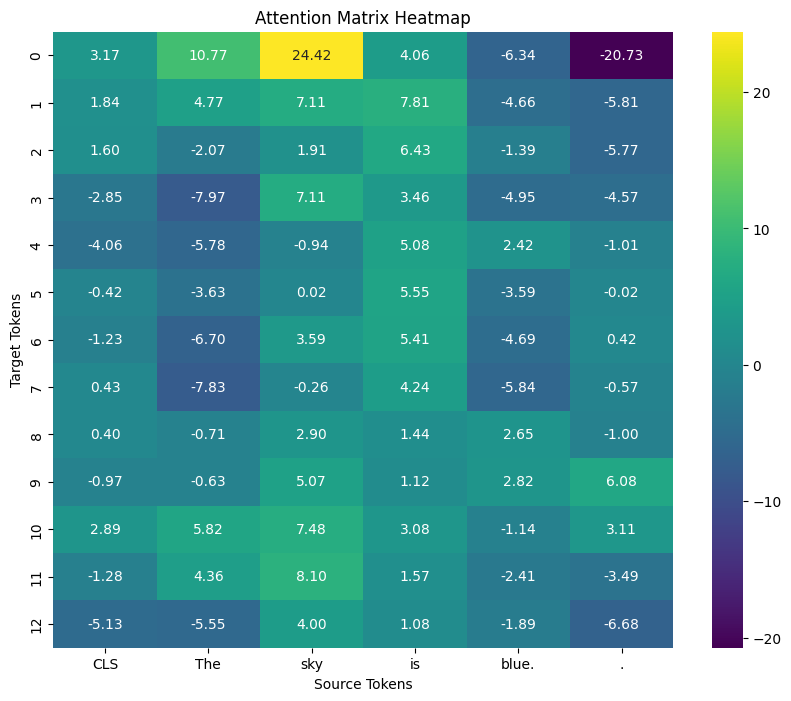

In [209]:
plt.figure(figsize=(10, 8))
sns.heatmap(attn_matrices[5,15,:13,:6].cpu().numpy(), annot=True, fmt=".2f", cmap='viridis', xticklabels=['CLS']+src.split()+['.'])#, yticklabels=translation.split())
plt.xlabel('Source Tokens')
plt.ylabel('Target Tokens')
plt.title('Attention Matrix Heatmap')
plt.show()

In [204]:
for token in tokenizer.encode(translation):
    print(tokenizer.decode(token))

[ C L S ]
आ
# # स
# # म
# # ा
# # न
न
# # ी
# # ल
# # ा
ह
।
[ S E P ]


In [ ]:
wandb.finish()